In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import openpyxl
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 32  # Set default font size
rcParams['axes.titlesize'] = 24
rcParams['axes.labelsize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 32

In [2]:
FILE_PATH = os.path.join('..', 'raw data', '20251103')
FIGSIZE = (10, 8)
TMP_DIR = "./tmp"

# Ensure temporary directories exist
os.makedirs(TMP_DIR, exist_ok=True)

dir_list = list(filter(lambda x: os.path.isdir(os.path.join(FILE_PATH, x)),
                       os.listdir(FILE_PATH)))
print(pd.DataFrame(dir_list, columns=['Dirs']).head(99))
directory = int(input('choose one directory:'))
FILE_PATH = os.path.join(FILE_PATH, dir_list[directory])
file_list = os.listdir(FILE_PATH)
file_list.sort(key=lambda x: os.path.getmtime(os.path.join(FILE_PATH, x)))
FormingDC_file_list = list(filter(lambda x: ' FormingDC' in x, file_list))
SetDC_file_list = list(filter(lambda x: ' SetDC' in x, file_list))
ResetDC_file_list = list(filter(lambda x: ' ResetDC' in x, file_list))
read_file_list = list(filter(lambda x: ' read' in x or ' ReadDC' in x, file_list))
file_list = list(filter(lambda x: ' FormingDC' in x or ' SetDC' in x
                        or ' ResetDC' in x, file_list))
FIG_TITLE = FILE_PATH.split('/')[-1].split('(')[0]

df = [[], [], [], []]
device_to_file = {}
for index, file in enumerate(file_list, start=1):
    curr_df = pd.read_csv(os.path.join(FILE_PATH, file)) if 'csv' in file \
        else pd.read_excel(os.path.join(FILE_PATH, file))
    length = curr_df.shape[0] - 1
    df[0].extend(curr_df.Vd.values[1:])
    df[1].extend(curr_df.Id.values[1:])
    df[2].extend([index] * length)
    device_to_file[f'{index}'] = file
    operation = (['Forming'] if ' FormingDC' in file
                 else ['Set'] if ' SetDC' in file
                 else ['Reset'] if ' ResetDC' in file else None)
    df[3].extend(operation * length)
df = pd.DataFrame(np.transpose(df),
                  columns=['Vd (V)', 'Id (A)', 'Device', 'Operation'])
df['Vd (V)'] = pd.to_numeric(df['Vd (V)'])
df['Id (A)'] = pd.to_numeric(df['Id (A)'], errors='coerce')
df['abs(Id)'] = abs(df['Id (A)'])
df['Resistance (Ohm)'] = \
    abs(df['Vd (V)'] / df['Id (A)']).where(df['Vd (V)'] != 0)

                          Dirs
0    3HfO2_NoAnneal_1_6_01to50
1  3HfO2_NoAnneal_1_6_101to130
2  3HfO2_NoAnneal_1_6_131to160
3    3HfO2_NoAnneal_1_6_51to80
4   3HfO2_NoAnneal_1_6_81to100


choose one directory: 4


In [3]:
print(FILE_PATH)
print(FIG_TITLE)

../raw data/20251103/3HfO2_NoAnneal_1_6_81to100
3HfO2_NoAnneal_1_6_81to100


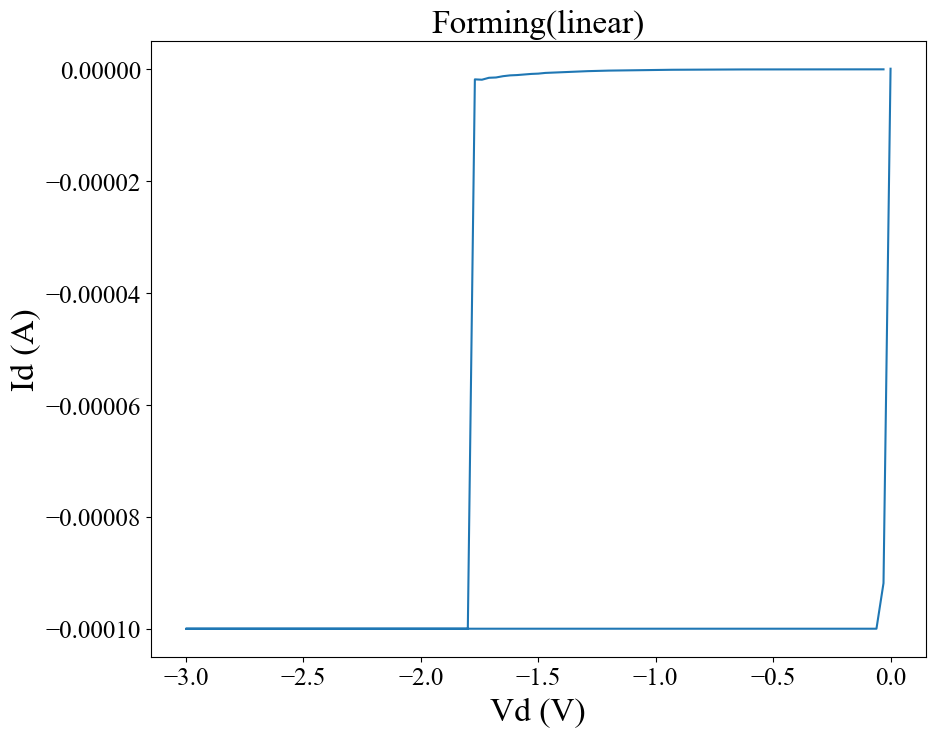

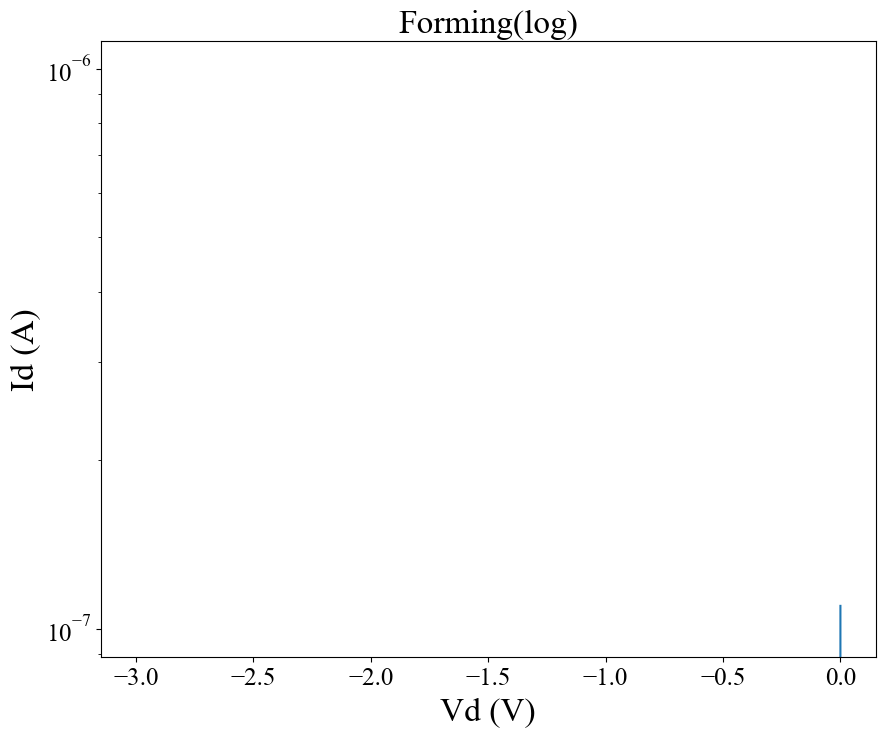

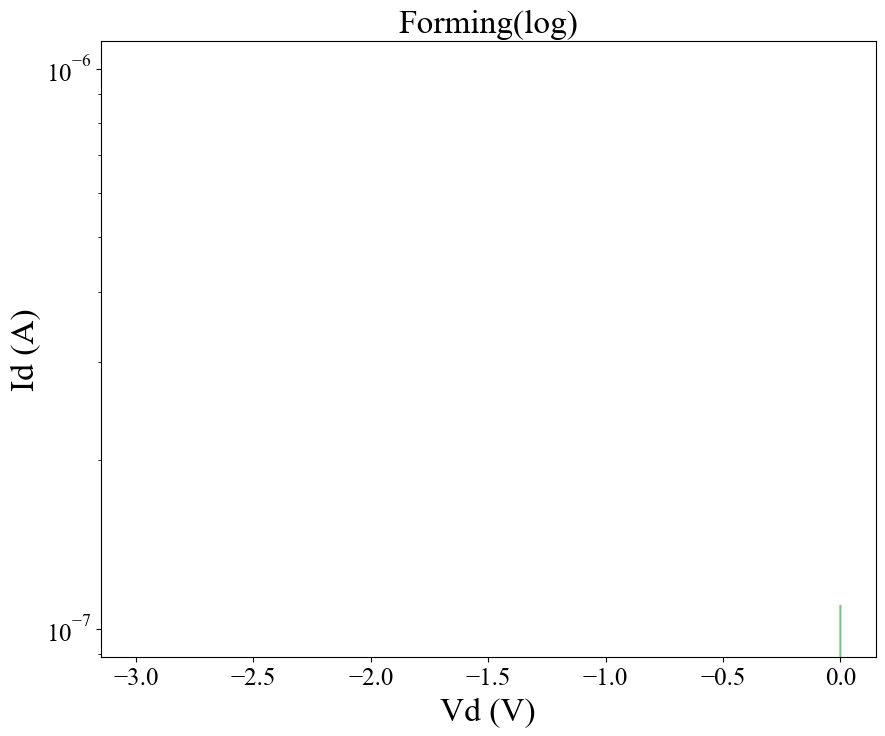

In [4]:
if len(FormingDC_file_list) != 0:
    forming_df = df[df.Operation == 'Forming']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)
    sns.lineplot(data=forming_df, x='Vd (V)', y='Id (A)', estimator=None,
                 sort=False)
    plt.title("Forming(linear)")
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)
    sns.lineplot(data=forming_df, x='Vd (V)', y='Id (A)', estimator=None,
                 sort=False)
    ax.set(title="Forming(log)", yscale='log')
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)
    sns.lineplot(data=forming_df, x='Vd (V)', y='Id (A)', hue='Device',
                 palette='YlGn', estimator=None, sort=False, legend=False, ax=ax)
    ax.set(title="Forming(log)", yscale='log')
    plt.show()

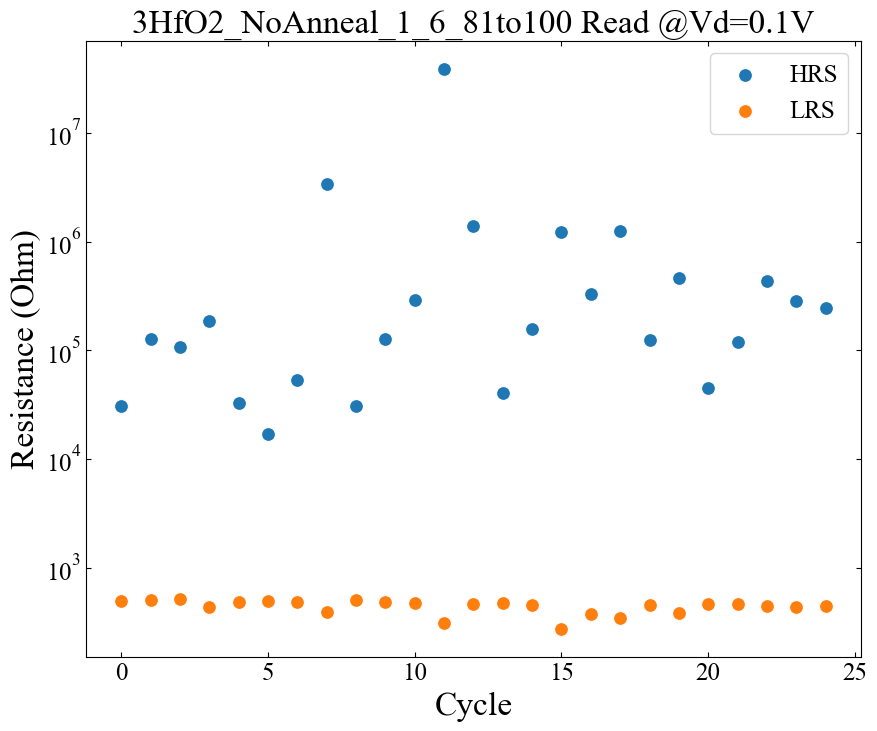

In [5]:
def load_single_file(file: str) -> pd.DataFrame:
    """
    Loads a single file (CSV or Excel) and returns its contents as a DataFrame.
    """
    file_full = os.path.join(FILE_PATH, file)
    if "csv" in file.lower():
        return pd.read_csv(file_full)
    else:
        return pd.read_excel(file_full)


def extract_measurement(df: pd.DataFrame) -> list:
    """
    Extracts measurement values from a DataFrame.
    Returns a list containing the absolute values of Id and Vd from the second row.
    """
    try:
        # Use .iloc[1] for clarity; you might want to add checks if the DataFrame is empty
        _current = abs(pd.to_numeric(df.loc[1, "Id"]))
        _voltage = abs(pd.to_numeric(df.loc[1, "Vd"]))
        return [_current, _voltage]
    except (IndexError, KeyError) as e:
        print("Error extracting measurement:", e)
        print(df)
        return None


def process_file_group(file_list: list) -> pd.DataFrame:
    """
    Process a list of files into a DataFrame containing 'Id' and 'Vd' columns.
    Also computes resistance as Vd/Id.
    """
    measurements = []
    for file in file_list:
        df_file = load_single_file(file)
        meas = extract_measurement(df_file)
        if meas is not None:
            measurements.append(meas)
    if len(measurements) == 0:
        raise ValueError("No valid measurements found in file list.")
    df_result = pd.DataFrame(np.array(measurements), columns=["Id", "Vd"])
    df_result["Res"] = df_result.Vd / df_result.Id
    return df_result


def process_read_files_MIM(read_file_list: list) -> list:
    """
    Processes files from a given list for two groups (read1/HRS and read2/LRS).
    Returns a list with two DataFrames: [HRS, LRS].
    """
    # Filter files into groups based on naming patterns
    read1_files = [f for f in read_file_list if " read1" in f or " ReadDC1" in f]
    read2_files = [f for f in read_file_list if " read2" in f or " ReadDC2" in f]

    df_read1 = process_file_group(read1_files)
    df_read2 = process_file_group(read2_files)

    # Plot the combined read data
    plot_read_data(df_read1, df_read2)

    return [df_read1, df_read2]

    # df_read = process_file_group(read_file_list)
    # plot_read_data(df_read)
    # return [df_read]


def plot_read_data(df1: pd.DataFrame, df2: pd.DataFrame = None):
    """
    Plots the resistance for the two sets of read data.
    """
    fig, ax = plt.subplots(figsize=FIGSIZE)
    title = f"{FIG_TITLE} Read @Vd={df1.loc[0, 'Vd']}V"
    ax.set(title=title, xlabel="Cycle", ylabel="Resistance (Ohm)", yscale="log")
    sns.scatterplot(x=df1.index, y=df1.Res, label="HRS", ax=ax, markers="o", s=100)
    sns.scatterplot(x=df2.index, y=df2.Res, label="LRS", ax=ax, markers="o", s=100)
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
    plt.legend()
    output_file = os.path.join(TMP_DIR, f"{FIG_TITLE}_read_a.png")
    plt.savefig(output_file)
    plt.show()


read_df = process_read_files_MIM(read_file_list)

       Vd (V)        Id (A) Device Operation       abs(Id)  Resistance (Ohm)
402    -0.013 -4.207260e-07      3       Set  4.207260e-07      30898.969876
403    -0.026 -8.456480e-07      3       Set  8.456480e-07      30745.653038
404    -0.039 -1.277490e-06      3       Set  1.277490e-06      30528.614705
405    -0.052 -1.697000e-06      3       Set  1.697000e-06      30642.309959
406    -0.065 -2.136100e-06      3       Set  2.136100e-06      30429.287018
...       ...           ...    ...       ...           ...               ...
10246  -0.052 -1.165130e-04     51       Set  1.165130e-04        446.302129
10247  -0.039 -8.740990e-05     51       Set  8.740990e-05        446.173717
10248  -0.026 -5.830910e-05     51       Set  5.830910e-05        445.899525
10249  -0.013 -2.921730e-05     51       Set  2.921730e-05        444.941867
10250   0.000 -1.149847e-07     51       Set  1.149847e-07               NaN

[5025 rows x 6 columns]


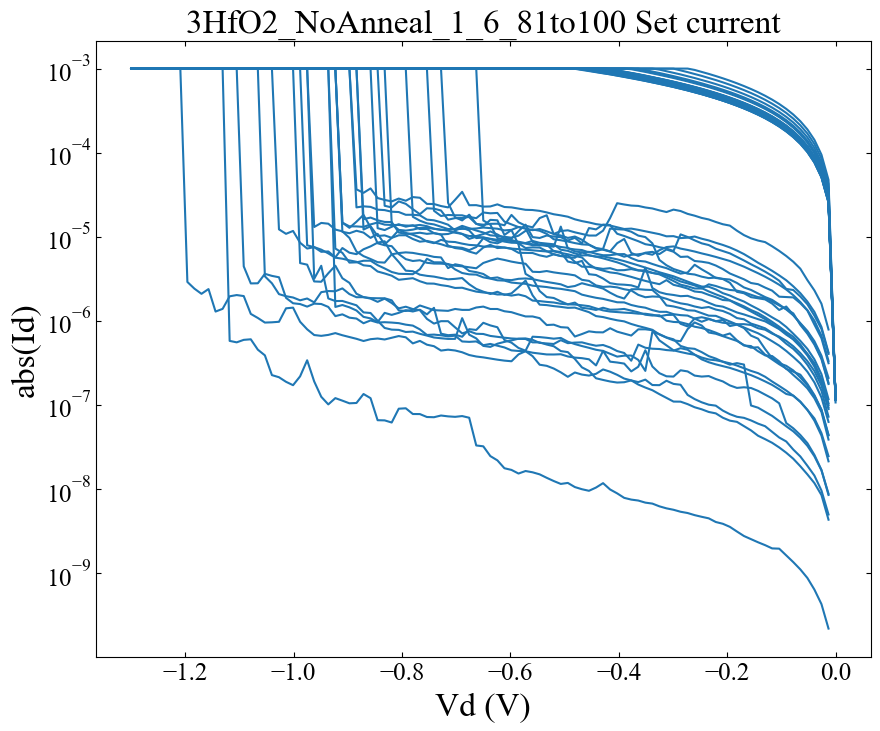

       Vd (V)        Id (A) Device Operation       abs(Id)  Resistance (Ohm)
402    -0.013 -4.207260e-07      3       Set  4.207260e-07      30898.969876
403    -0.026 -8.456480e-07      3       Set  8.456480e-07      30745.653038
404    -0.039 -1.277490e-06      3       Set  1.277490e-06      30528.614705
405    -0.052 -1.697000e-06      3       Set  1.697000e-06      30642.309959
406    -0.065 -2.136100e-06      3       Set  2.136100e-06      30429.287018
...       ...           ...    ...       ...           ...               ...
10246  -0.052 -1.165130e-04     51       Set  1.165130e-04        446.302129
10247  -0.039 -8.740990e-05     51       Set  8.740990e-05        446.173717
10248  -0.026 -5.830910e-05     51       Set  5.830910e-05        445.899525
10249  -0.013 -2.921730e-05     51       Set  2.921730e-05        444.941867
10250   0.000 -1.149847e-07     51       Set  1.149847e-07               NaN

[5025 rows x 6 columns]


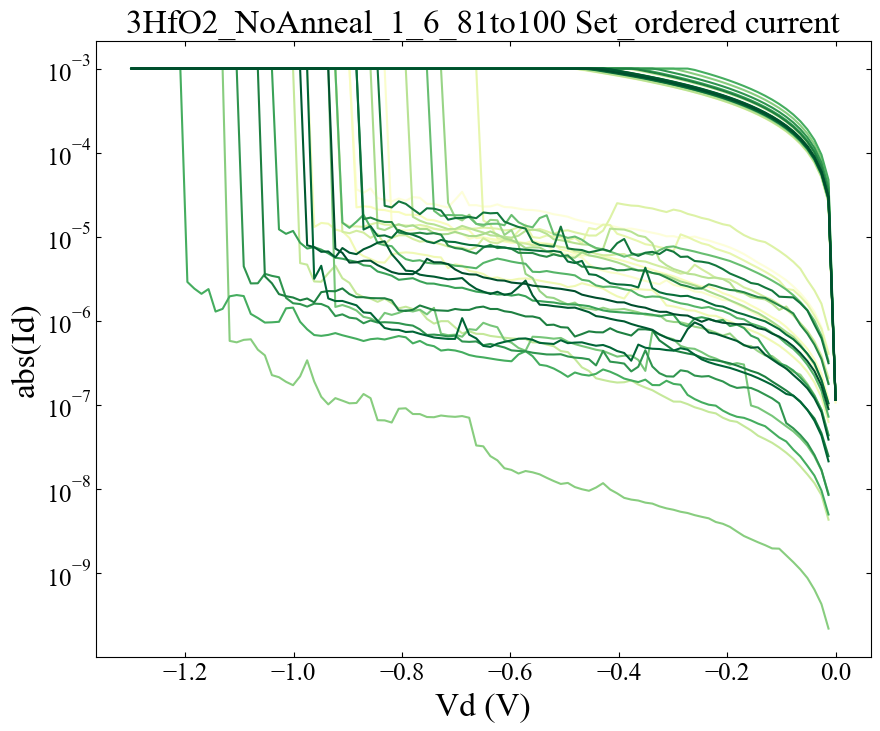

       Vd (V)        Id (A) Device Operation       abs(Id)  Resistance (Ohm)
201     0.013  3.910390e-05      2     Reset  3.910390e-05        332.447659
202     0.026  7.818010e-05      2     Reset  7.818010e-05        332.565448
203     0.039  1.175440e-04      2     Reset  1.175440e-04        331.790649
204     0.052  1.571760e-04      2     Reset  1.571760e-04        330.839314
205     0.065  1.971630e-04      2     Reset  1.971630e-04        329.676461
...       ...           ...    ...       ...           ...               ...
10045   0.052  1.957630e-07     50     Reset  1.957630e-07     265627.314661
10046   0.039  1.473940e-07     50     Reset  1.473940e-07     264596.930676
10047   0.026  9.853760e-08     50     Reset  9.853760e-08     263858.669178
10048   0.013  4.889150e-08     50     Reset  4.889150e-08     265894.889705
10049   0.000 -2.154280e-10     50     Reset  2.154280e-10               NaN

[5025 rows x 6 columns]


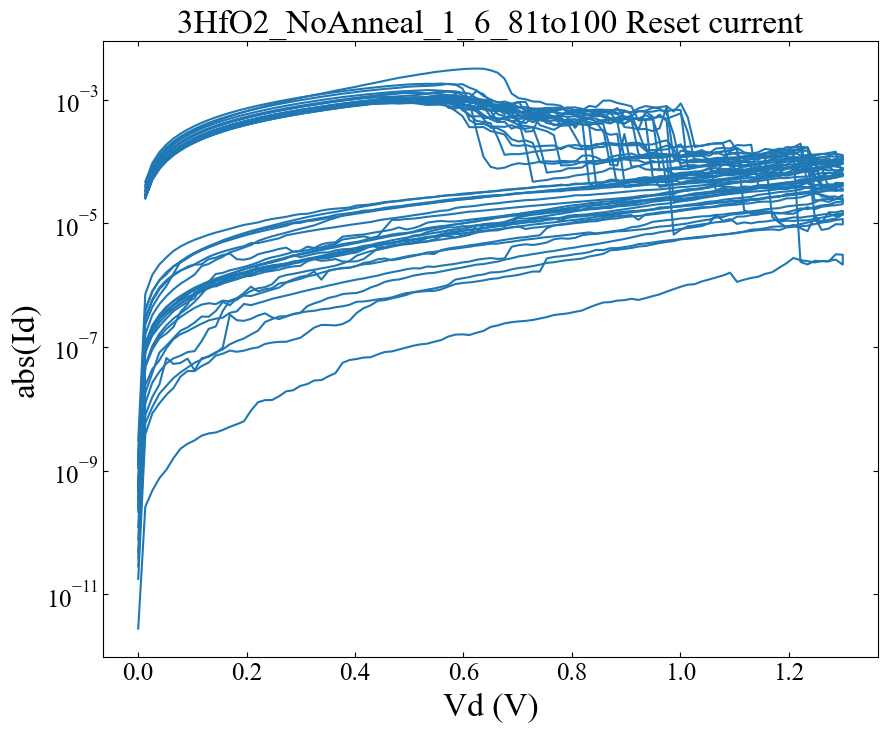

       Vd (V)        Id (A) Device Operation       abs(Id)  Resistance (Ohm)
201     0.013  3.910390e-05      2     Reset  3.910390e-05        332.447659
202     0.026  7.818010e-05      2     Reset  7.818010e-05        332.565448
203     0.039  1.175440e-04      2     Reset  1.175440e-04        331.790649
204     0.052  1.571760e-04      2     Reset  1.571760e-04        330.839314
205     0.065  1.971630e-04      2     Reset  1.971630e-04        329.676461
...       ...           ...    ...       ...           ...               ...
10045   0.052  1.957630e-07     50     Reset  1.957630e-07     265627.314661
10046   0.039  1.473940e-07     50     Reset  1.473940e-07     264596.930676
10047   0.026  9.853760e-08     50     Reset  9.853760e-08     263858.669178
10048   0.013  4.889150e-08     50     Reset  4.889150e-08     265894.889705
10049   0.000 -2.154280e-10     50     Reset  2.154280e-10               NaN

[5025 rows x 6 columns]


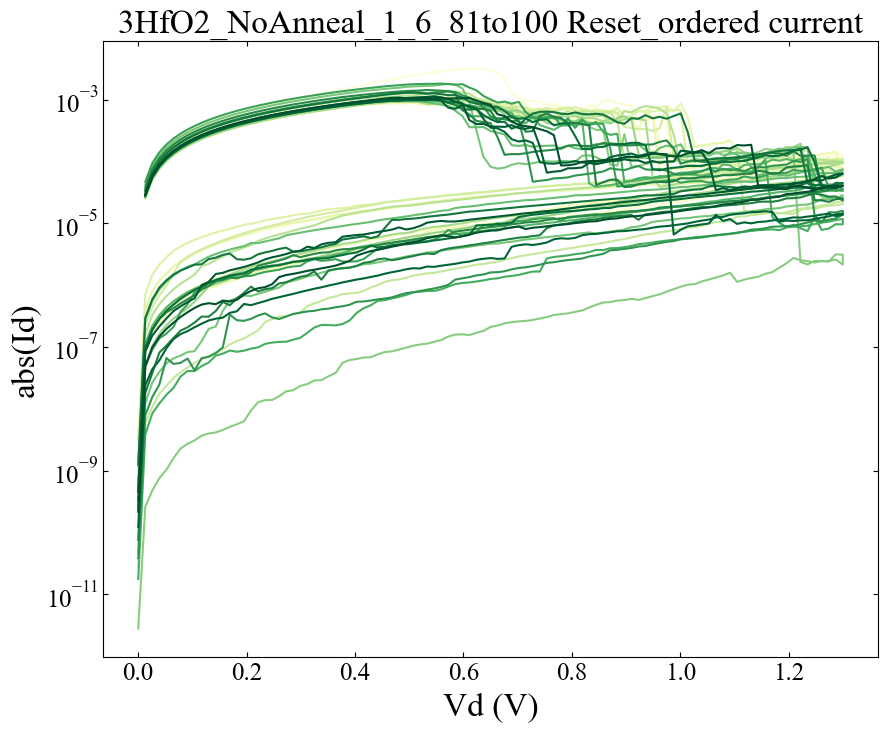

In [6]:
def plot_operation(df: pd.DataFrame, operation: str, plot_kwargs: dict = None, save_suffix: str = None):
    """
    Generic function to plot operation data.

    Parameters:
      df         : DataFrame containing operation data (e.g., 'Set' or 'Reset')
      operation  : Operation type, e.g., "Set" or "Reset"
      plot_kwargs: Additional keyword arguments for sns.lineplot
      save_suffix: Suffix for the output filename (if not provided, uses operation.lower())
    """
    plot_kwargs = plot_kwargs or {}
    save_suffix = save_suffix or operation.lower()

    fig, ax = plt.subplots(figsize=FIGSIZE)
    title = f"{FIG_TITLE} {operation} current"
    ax.set(title=title,xscale='linear', yscale='log')

    # Choose whether to use hue or not based on kwargs
    print(df)
    sns.lineplot(data=df, x="Vd (V)", y="abs(Id)", units="Device", estimator=None, sort=False, ax=ax, **plot_kwargs)

    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
    output_file = os.path.join(TMP_DIR, f"{FIG_TITLE}_{save_suffix}.png")
    plt.savefig(output_file)
    plt.show()


# Plot for Set operation (basic version)
set_df = df[df.Operation == "Set"]
plot_operation(set_df, "Set")

# Plot for Set operation with ordered hues
plot_operation(set_df, "Set_ordered",
               plot_kwargs={"hue": "Device", "palette": "YlGn", "legend": False})

reset_df = df[df.Operation == "Reset"]
plot_operation(reset_df, "Reset")
plot_operation(reset_df, "Reset_ordered", plot_kwargs={"hue": "Device", "palette": "YlGn", "legend": False})

In [7]:
def find_turning_points(df, operation, resistance_column="Resistance (Ohm)", voltage_column="Vd (V)", threshold=None):
    """
    Finds turning points in a single I-V curve (from a DataFrame)
    where the resistance changes abruptly.

    Parameters:
        df (pd.DataFrame): DataFrame containing a single I-V curve.
        resistance_column (str): Column name for resistance values.
        voltage_column (str): Column name for voltage values.
        threshold (float, optional): Threshold for the absolute derivative.
            If None, defaults to mean(abs(derivative)) + 2 * std(abs(derivative)).

    Returns:
        np.ndarray: Voltage values at the turning points.
    """
    voltage = df[voltage_column].values[10:]
    resistance = df[resistance_column].values[10:]

    # Compute the derivative of resistance with respect to voltage.
    dR = np.gradient(resistance, voltage)
    log_dR = np.log10(np.abs(dR))

    if threshold is None:
        # Set default threshold if not provided
        threshold = df_read2.mean() + 2 * df_read2.std()

    # Find indices where the absolute derivative exceeds the threshold.
    turning_indices = np.where(resistance < threshold) if operation == 'Set' else np.where(resistance > threshold)
    turning_voltages = voltage[turning_indices]
    try:
        turning_voltages = turning_voltages[0]
    except:
        turning_voltages = -2.8 if operation == 'Set' else -5

    print(turning_voltages)
    return turning_voltages


def find_turning_points_by_device(df, operation, device_column="Device", voltage_column="Vd (V)", resistance_column="Resistance (Ohm)", threshold=None):
    """
    Finds turning points in the I-V curves for each device in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing multiple I-V curves.
        device_column (str): Column name that labels each device.
        voltage_column (str): Column name for voltage values.
        resistance_column (str): Column name for resistance values.
        threshold (float, optional): Threshold for the absolute derivative.
            If None, defaults to mean(abs(derivative)) + 2 * std(abs(derivative)) for each device.

    Returns:
        tuple: A dictionary mapping each device to its turning voltages, and a flattened np.array of all turning voltages.
    """
    turning_points = {}
    all_turning_voltages = []

    # Group the data by device
    for device, group in df.groupby(device_column):
        # Sort each group by voltage, if not already sorted
        group_sorted = group.sort_values(by=voltage_column)
        voltages = find_turning_points(group_sorted, operation, resistance_column, voltage_column, threshold)
        turning_points[device] = voltages
        all_turning_voltages.append(voltages * -1)

    return turning_points, np.array(all_turning_voltages)


def plot_turning_points_histogram(turning_voltages, operation, bins=50):
    """
    Plots a histogram of turning point voltages.

    Parameters:
        turning_voltages (np.ndarray): Array of voltage values at turning points.
        bins (int): Number of bins in the histogram.
    """
    plt.figure(figsize=FIGSIZE)
    plt.hist(turning_voltages, bins=bins, edgecolor="black", cumulative=True)
    plt.xlim(0, 3 if operation == 'Set' else 5.1)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {operation} Voltages")
    plt.show()


# # threshold = np.array(read_df[1]).mean() + 2 * np.array(read_df[1]).std()
# threshold = 3e5

# turning_points_dict, all_turning_voltages = find_turning_points_by_device(set_df[set_df["Vd (V)"]<-1], operation='Set', threshold=threshold)
# # Now, plot the histogram of all detected turning point voltages.
# plot_turning_points_histogram(all_turning_voltages, operation='Set')

# turning_points_dict, all_turning_voltages = find_turning_points_by_device(reset_df[reset_df["Vd (V)"]<-1], operation='Reset', threshold=threshold)
# plot_turning_points_histogram(all_turning_voltages, operation='Reset')

In [8]:
def find_failed_rounds():
    successed_setting = [[], []]
    successed_setting[0] = read_df[0].Res > 1e5
    successed_setting[1] = read_df[1].Res < 2e4
    successed_setting = successed_setting[0] & successed_setting[1]
    successed_setting_df = [read_df[0].Id[successed_setting], read_df[1].Id[successed_setting]]
    print('successed_setting:', len(successed_setting_df[0]), '\n', successed_setting_df[0].index.tolist())
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)
    ax.set(title='successed_setting', yscale='log', xlabel='')
    sns.scatterplot(x=successed_setting_df[0].index, y=successed_setting_df[0], label="LRS", ax=ax, markers="o")
    sns.scatterplot(x=successed_setting_df[0].index, y=successed_setting_df[1], label="HRS", ax=ax, markers="o")
    plt.show()

    failed_setting = (successed_setting == False)
    read1_file_list = list(filter(lambda x: ' read1' in x or ' ReadDC1' in x, read_file_list))
    read2_file_list = list(filter(lambda x: ' read2' in x or ' ReadDC2' in x, read_file_list))
    print(pd.DataFrame(read1_file_list)[failed_setting])

    devices = len(set_df.Device.unique())
    set_Id = set_df['abs(Id)'].values.reshape(devices, -1)
    reset_Id = reset_df['abs(Id)'].values.reshape(devices, -1)
#     for i in range(10):
#         sns.lineplot(data=Reset_Id[:, -i])
#         plt.show()


# find_failed_rounds()

In [9]:
def export_for_origin(read_df: list, set_df: pd.DataFrame, reset_df: pd.DataFrame):
    """
    Exports the provided data frames to an Excel file for Origin.
    """
    readLRS, readHRS = read_df
    devices = len(set_df.Device.unique())
    # Construct Set_Id and Reset_Id DataFrames
    set_vd_vector = set_df[set_df.Device == set_df.Device.unique()[0]]["Vd (V)"]
    set_values = np.vstack((set_vd_vector, set_df["abs(Id)"].values.reshape(devices, -1)))
    set_id_df = pd.DataFrame(set_values.T, columns=["Vd", *[f"Id{x}" for x in range(devices)]])

    reset_vd_vector = reset_df[reset_df.Device == reset_df.Device.unique()[0]]["Vd (V)"]
    reset_values = np.vstack((reset_vd_vector, reset_df["abs(Id)"].values.reshape(devices, -1)))
    reset_id_df = pd.DataFrame(reset_values.T, columns=["Vd", *[f"Id{x}" for x in range(devices)]])

    # Create a excel file for origin
    output_file = os.path.join(FILE_PATH, "for_origin.xlsx")
    empty_df = pd.DataFrame()
    empty_df.to_excel(output_file)
    print("Exporting to:", output_file)

    with pd.ExcelWriter(output_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        readLRS.to_excel(writer, sheet_name="HRS", index=False)
        readHRS.to_excel(writer, sheet_name="LRS", index=False)
        set_id_df.to_excel(writer, sheet_name="Set", index=False)
        reset_id_df.to_excel(writer, sheet_name="Reset", index=False)


export_for_origin(read_df, set_df, reset_df)

Exporting to: ../raw data/20251103/3HfO2_NoAnneal_1_6_81to100/for_origin.xlsx


In [10]:
def plot_resistance_distribution(df: pd.DataFrame):
    """
    Plots a histogram of resistance values from the DataFrame.
    """
    res = df["Resistance (Ohm)"]
    groups = list(range(0, 10000000, 100000))
    groups.append(np.inf)
    grouped = res.groupby(pd.cut(res, groups), observed=False).count()

    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set(title="Count of resistance", xlabel="Resistance (Ohm)", ylabel="Count")
    plt.plot(groups[:-1], grouped.values)
    plt.show()


def plot_gradient(df: pd.DataFrame):
    """
    Computes and plots the gradient of the resistance with respect to Vd.
    """
    df["d(res)/d(Vd)"] = np.gradient(df["Resistance (Ohm)"])
    df["d(res)/d(Vd)"] = df["d(res)/d(Vd)"].mask(df["Resistance (Ohm)"].isnull())

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set(title="Gradient of Resistance", xlabel="Vd (V)")
    for device in df[df.Operation == "Set"].Device.unique():
        sns.lineplot(
            data=df[df.Device == device],
            x="Vd (V)",
            y="d(res)/d(Vd)",
            estimator=None,
            sort=False,
            lw=1,
            ax=ax,
            label=str(device)
        )
    plt.show()


# plot_resistance_distribution(df)
# plot_gradient(df)

In [11]:
def process_read_files():
    read1_file_list = list(filter(lambda x: ' read1' in x or ' ReadDC1' in x, read_file_list))
    read2_file_list = list(filter(lambda x: ' read2' in x or ' ReadDC2' in x, read_file_list))
    read_df = {'-0.1_read1': [], '-0.1_read2': [],
               '-0.3_read1': [], '-0.3_read2': [],
               '0.1_read1': [], '0.1_read2': [],
               '0.3_read1': [], '0.3_read2': []}
    for index, file in enumerate(read1_file_list):
        curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
            else pd.read_excel(os.path.join(file_path, file))
        try:
            read_df[f'{curr_df.Vd[1]}_read1'].append(curr_df.Id[1])
        except IndexError:
            print('Failing reading file:', file)
            print(curr_df)

    for index, file in enumerate(read2_file_list):
        curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
            else pd.read_excel(os.path.join(file_path, file))
        try:
            read_df[f'{curr_df.Vd[1]}_read2'].append(curr_df.Id[1])
        except IndexError:
            print('Failing reading file:', file)
            print(curr_df)

    read_df['-0.1'] = [read_df['-0.1_read1'], read_df['-0.1_read2']]
    read_df['-0.3'] = [read_df['-0.3_read1'], read_df['-0.3_read2']]
    read_df['0.1'] = [read_df['0.1_read1'], read_df['0.1_read2']]
    read_df['0.3'] = [read_df['0.3_read1'], read_df['0.3_read2']]
    print(read_df['-0.1'], read_df['-0.3'], read_df['0.1'], read_df['0.3'])
    if '1t1r' in fig_title:
        columns = ["abs(LRS current)", "abs(HRS current)"]
    else:
        columns = ["abs(HRS current)", "abs(LRS current)"]
    read_df['-0.1'] = pd.DataFrame(np.abs(np.array(read_df['-0.1'])).T, columns=columns)
    read_df['-0.3'] = pd.DataFrame(np.abs(np.array(read_df['-0.3'])).T, columns=columns)
    read_df['0.1'] = pd.DataFrame(np.abs(np.array(read_df['0.1'])).T, columns=columns)
    read_df['0.3'] = pd.DataFrame(np.abs(np.array(read_df['0.3'])).T, columns=columns)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.set(title=f'{fig_title} Read @-0.1V', yscale='log', xlabel='')
    sns.lineplot(x=read_df['-0.1'].index, y=read_df['-0.1']["abs(LRS current)"], label="LRS", ax=ax)
    sns.lineplot(x=read_df['-0.1'].index, y=read_df['-0.1']["abs(HRS current)"], label="HRS", ax=ax)
    plt.legend()
    plt.savefig(f'tmp/{fig_title}_read_a.png')
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.set(title=f'{fig_title} Read @-0.3V', yscale='log', xlabel='')
    sns.lineplot(x=read_df['-0.3'].index, y=read_df['-0.3']["abs(LRS current)"], label="LRS", ax=ax)
    sns.lineplot(x=read_df['-0.3'].index, y=read_df['-0.3']["abs(HRS current)"], label="HRS", ax=ax)
    plt.legend()
    plt.savefig(f'tmp/{fig_title}_read_b.png')
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.set(title=f'{fig_title} Read @0.1V', yscale='log', xlabel='')
    sns.lineplot(x=read_df['0.1'].index, y=read_df['0.1']["abs(LRS current)"], label="LRS", ax=ax)
    sns.lineplot(x=read_df['0.1'].index, y=read_df['0.1']["abs(HRS current)"], label="HRS", ax=ax)
    plt.legend()
    plt.savefig(f'tmp/{fig_title}_read_c.png')
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.set(title=f'{fig_title} Read @0.3V', yscale='log', xlabel='')
    sns.lineplot(x=read_df['0.3'].index, y=read_df['0.3']["abs(LRS current)"], label="LRS", ax=ax)
    sns.lineplot(x=read_df['0.3'].index, y=read_df['0.3']["abs(HRS current)"], label="HRS", ax=ax)
    plt.legend()
    plt.savefig(f'tmp/{fig_title}_read_d.png')
    plt.show()

    if 'STO3+3_1t1r_3050' in file_path:
        read_df = read_df['-0.3']
        successed_setting = read_df[read_df['abs(LRS current)'] > 1e-6]
        print('successed_setting:\n', successed_setting.index.tolist())
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        ax.set(title='successed_setting', yscale='log', xlabel='')
        sns.lineplot(x=successed_setting.index, y=successed_setting["abs(LRS current)"], label="LRS", ax=ax)
        sns.lineplot(x=successed_setting.index, y=successed_setting["abs(HRS current)"], label="HRS", ax=ax)
        plt.show()
        successed_setting = successed_setting.index.tolist()

In [12]:
def process_read_files_2(read_file_list):
    read1_file_list = list(filter(lambda x: ' read1' in x or ' ReadDC1' in x, read_file_list))
    read2_file_list = list(filter(lambda x: ' read2' in x or ' ReadDC2' in x, read_file_list))
    read_df = [[], []]
    for index, file in enumerate(read1_file_list):
        curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
            else pd.read_excel(os.path.join(file_path, file))
        try:
            read_df[0].append([curr_df.Id[1], curr_df.Vd[1], curr_df.Vg[1]])
        except IndexError:
            print('Failing reading file:', file)
            print(curr_df)

    for index, file in enumerate(read2_file_list):
        curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
            else pd.read_excel(os.path.join(file_path, file))
        try:
            read_df[1].append([curr_df.Id[1], curr_df.Vd[1], curr_df.Vg[1]])
        except IndexError:
            print('Failing reading file:', file)
            print(curr_df)

    columns = ["Id", "Vd", "Vg"]
    read_df[0] = pd.DataFrame(np.abs(np.array(read_df[0])), columns=columns)
    read_df[1] = pd.DataFrame(np.abs(np.array(read_df[1])), columns=columns)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.set(title=f'{fig_title} Read @Vd={read_df[0].Vd[0]}V, Vg={read_df[0].Vg[0]}V', yscale='log', xlabel='', ylabel='Id (A)')
    sns.lineplot(x=read_df[0].index, y=read_df[0].Id, label="LRS", ax=ax)
    sns.lineplot(x=read_df[1].index, y=read_df[1].Id, label="HRS", ax=ax)
    plt.legend()
    plt.savefig(f'tmp/{fig_title}_read_a.png')
    plt.show()

    return read_df


# read_df = process_read_files_2(read_file_list)